## Sonification Implementation
This notebook contains the paper implementation of the sonification section of this research paper.
The goal of this sonification pipeline is to create an audio file for each dataset, where a geiger counter noise will be inserted between the peak frequencies of the spectogram generated for each dataset.

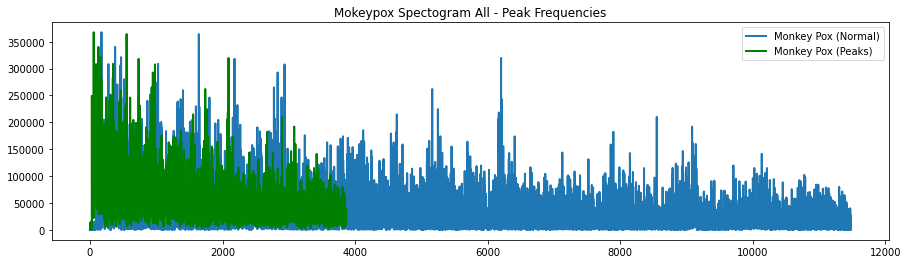

In [1]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

filemp = open("./monkeypox/monkeypox-dataset-variables.p", 'rb')
filecv = open("./covid_19/covid_19-dataset-variables.p", "rb")
MP_DATASET_VARS = pickle.load(filemp)
CV_DATASET_VARS = pickle.load(filecv)
filemp.close()
filecv.close()

dataMap = [
    {
      "title":"(Monkeypox)",
      "network": MP_DATASET_VARS["complete_network"],
      "analysis": "./monkeypox/csv_datasets/monkeypox - 2nd_network_analysis_raw_data.csv",
      "audio":"./monkeypox/audio_outputs/monkeypox - spectrogram_audio.wav",
      "energy_txt":"./monkeypox/monkeypox-bot_energy.txt",   
      "ne": MP_DATASET_VARS["node_entanglement"],
      "de": np.array(MP_DATASET_VARS["eigen_decomposition"]).flatten().real,
      "dataVAR": MP_DATASET_VARS,
      "name_space": "monkeypox"
    },
     {
      "title":"(Covid19)",
      "network": CV_DATASET_VARS["complete_network"],
      "analysis": "./covid_19/csv_datasets/covid_19 - 2nd_network_analysis_raw_data.csv",
      "audio": "./covid_19/audio_outputs/covid_19 - spectrogram_audio.wav",
      "energy_txt":"./covid_19/covid_19-bot_energy.txt" ,
      "ne": CV_DATASET_VARS["node_entanglement"],
      "de": np.array(CV_DATASET_VARS["eigen_decomposition"]).flatten().real,
      "dataVAR": CV_DATASET_VARS,
      "name_space": "covid_19"
    },
    ]

beneMap = []
baseSpecFlat = []
allPfc = []
inSpec = []

for item in dataMap: 
   
    sample_rate, samples = wavfile.read(item["audio"])
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    flat_spec = spectrogram.flatten()
    peak_widths = np.arange(0.1, 1)
    peak_indexes = signal.find_peaks_cwt(flat_spec, peak_widths)
    peak_frequencies = []
    pfc = []
    bot_energy = np.loadtxt(item["energy_txt"], delimiter=",").flatten()

    # parse peak frequencies
    for ix in peak_indexes:
        peak_frequencies.append(flat_spec[ix])

    # parse pf with constant Hz
    for ix in peak_frequencies:
        pfc.append(ix)

    bene = pfc 
    bene.sort()
    beneMap.append(bene)
    baseSpecFlat.append(flat_spec)
    allPfc.append(peak_frequencies)
    inSpec.append(spectrogram)

    dfxbene = pd.DataFrame()
    dfxbene[f'network_energy_and_bot_energy'] = bene

fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Mokeypox Spectogram All - Peak Frequencies")
ax.plot(baseSpecFlat[0], linewidth=2, label="Monkey Pox (Normal)");
ax.plot(allPfc[0], linewidth=2, label="Monkey Pox (Peaks)", color="green");
ax.legend()  
plt.savefig(f"./sonification-workspace/images/Mokeypox Spectogram All - Peak Frequencies.png")

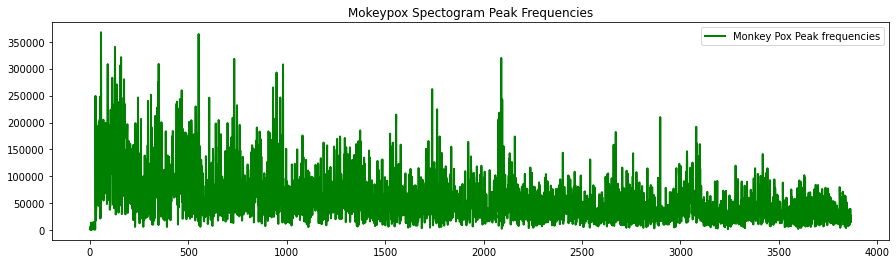

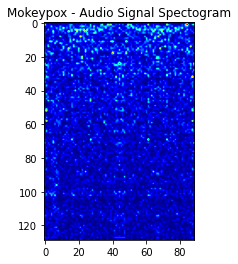

In [2]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Mokeypox Spectogram Peak Frequencies")
ax.plot(allPfc[0], linewidth=2, label="Monkey Pox Peak frequencies", color="green");
ax.legend()  
plt.savefig(f"./sonification-workspace/images/Mokeypox Spectogram Peak Frequencies.png")

fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Mokeypox - Audio Signal Spectogram")
ax.imshow(inSpec[0], interpolation="bilinear", cmap="jet")
plt.savefig(f"./sonification-workspace/images/Mokeypox - Audio Signal Spectogram.png")


## Covid19 Preprocessing

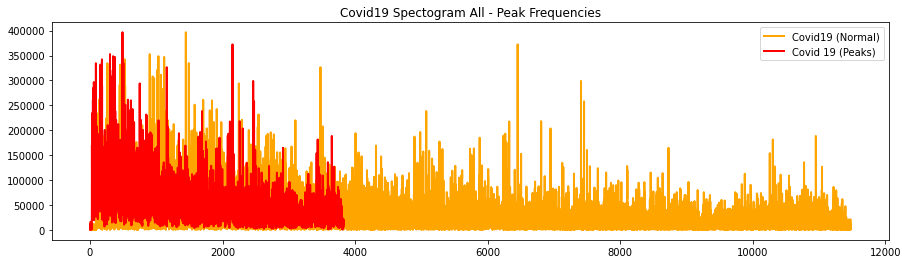

In [3]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Covid19 Spectogram All - Peak Frequencies")
ax.plot(baseSpecFlat[1], linewidth=2, label="Covid19 (Normal)", color="orange");
ax.plot(allPfc[1], linewidth=2, label="Covid 19 (Peaks)", color="red");
ax.legend()  
plt.savefig(f"./sonification-workspace/images/Covid19 Spectogram All - Peak Frequencies.png")


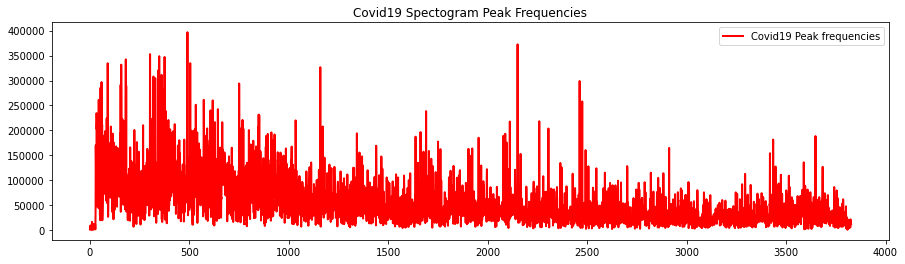

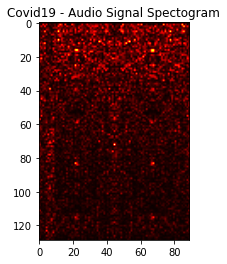

In [4]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Covid19 Spectogram Peak Frequencies")
ax.plot(allPfc[1], linewidth=2, label="Covid19 Peak frequencies", color="red");
ax.legend()  
plt.savefig(f"./sonification-workspace/images/Covid19 Spectogram Peak Frequencies.png")


fig, ax = plt.subplots(figsize=(15,4))
ax.set_title(f"Covid19 - Audio Signal Spectogram")
plt.savefig(f"./sonification-workspace/images/Covid19 - Audio Signal Spectogram.png")

ax.imshow(inSpec[1], interpolation="bilinear", cmap="hot")

## Sonification Process
Covers the sonification process for Monkey pox and Covid 19 datasets

In [5]:
from tqdm import tqdm
from pydub import AudioSegment
import random 

mp_base_noise = AudioSegment.from_file("./monkeypox/audio_outputs/monkeypox - spectrogram_audio.wav", format="wav")
cv_base_noise = AudioSegment.from_file("./covid_19/audio_outputs/covid_19 - spectrogram_audio.wav", format="wav")
s_geiger_tick = AudioSegment.from_file("./sonification-workspace/audio-inputs/geiger-tick.wav", format="wav")


dMap = [
    {
    "name": "monkeypox",
    "base_noise": mp_base_noise
    },
    {
    "name": "covid_19",
    "base_noise": cv_base_noise
    },
]


for i,x in enumerate(dMap):
    base_noise = x["base_noise"]
    sonficationOutput = base_noise
    bxf = baseSpecFlat[i]
    pxf = allPfc[i]

    for ax in tqdm(bxf):
        if ax in pxf:
            sonficationOutput = sonficationOutput+s_geiger_tick
        else:
            randVolumeDecrease = random.randint(15,45) 
            sonficationOutput = sonficationOutput + (base_noise - randVolumeDecrease)

    sonficationOutput.export(f"./sonification-workspace/audio-outputs/{x['name']}-sonification-output.wav", format="wav")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
  5%|▌         | 610/11481 [00:17<05:05, 35.54it/s] 


KeyboardInterrupt: 

### Count of Geiger Counter ticks produced
> Audio ticks produced per dataset

In [8]:
for i,x in enumerate(dMap):
    print(x["name"],"Total ticks =>", len(allPfc[i]))

monkeypox Total ticks => 3868
covid_19 Total ticks => 3827
